In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train', 'sample_submission.csv', 'test']


In [2]:
from fastai.vision import *

In [3]:
path = Path('../input')
path.ls()

[PosixPath('../input/train'),
 PosixPath('../input/sample_submission.csv'),
 PosixPath('../input/test')]

In [4]:
files = (path/'train').ls()
files[:4]

[PosixPath('../input/train/cat.8572.jpg'),
 PosixPath('../input/train/dog.11754.jpg'),
 PosixPath('../input/train/cat.3314.jpg'),
 PosixPath('../input/train/dog.11723.jpg')]

In [5]:
'../input/train/dog.864.jpg'.rsplit('/', 1)[-1].split('.')[0]

'dog'

In [6]:
def process_files(path):
    return path.stem.split('.')[0]

In [8]:
sz=224
bs=64

In [9]:
src = (ImageList.from_folder(path/'train')
       .split_by_rand_pct(0.2)
       .label_from_func(process_files)
       .add_test_folder('test'))

data = (src.transform(get_transforms(), size=sz)
       .databunch(bs=bs)
       .normalize(imagenet_stats))
    

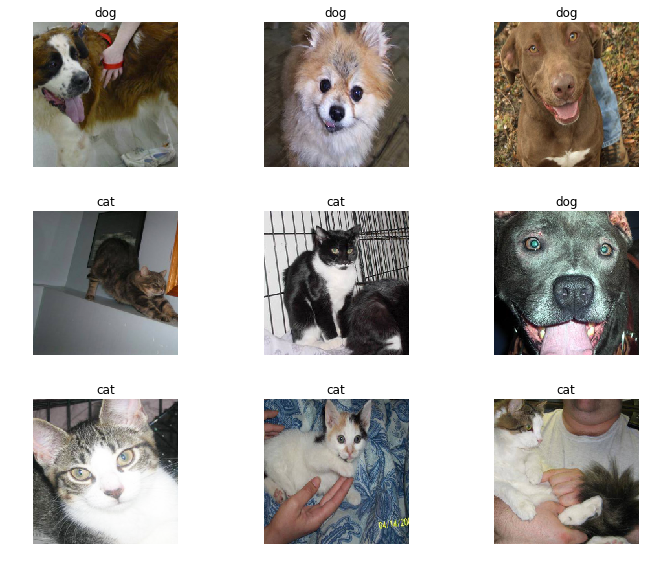

In [10]:
data.show_batch(rows=3, figsize=(10, 8))

In [11]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy], path='.')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.torch/models/resnet34-333f7ec4.pth
87306240it [00:13, 6651167.72it/s]


In [12]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


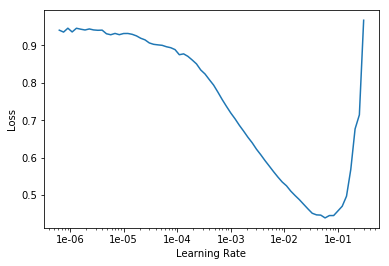

In [13]:
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(4, slice(1e-2))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.072106,0.026836,0.009200,0.990800,09:33
1,0.036924,0.017066,0.005800,0.994200,09:07
2,0.029508,0.013282,0.005200,0.994800,09:18
3,0.022092,0.011267,0.004600,0.995400,09:30


In [15]:
learn.save('stage-1')

In [17]:
interp = ClassificationInterpretation.from_learner(learn)

In [18]:
losses, idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

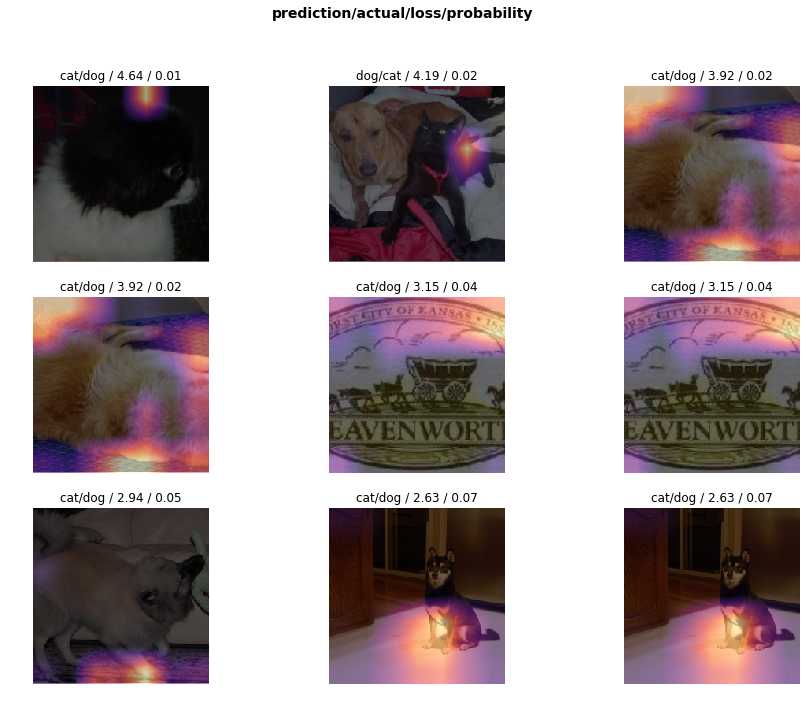

In [19]:
interp.plot_top_losses(9, figsize=(15,11))

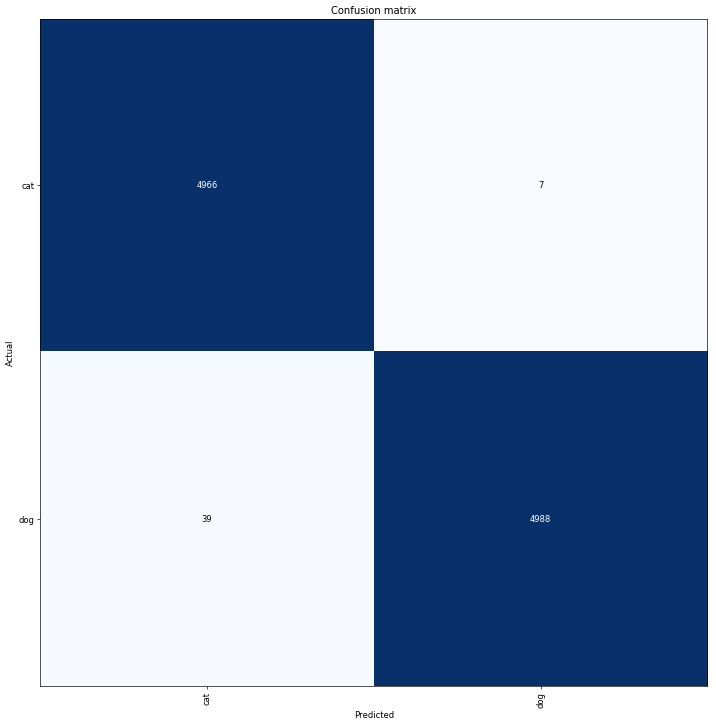

In [20]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [21]:
interp.most_confused(min_val=2)

[('dog', 'cat', 39), ('cat', 'dog', 7)]

In [22]:
learn.unfreeze()

In [24]:
learn.fit_one_cycle(2, max_lr=slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.083886,0.038132,0.014900,0.985100,09:38
1,0.039240,0.018562,0.006300,0.993700,09:39


In [25]:
learn.save('stage-2')

In [26]:
learn.freeze()

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


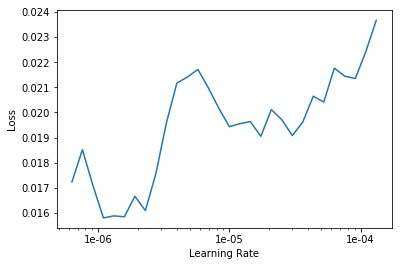

In [33]:
learn.recorder.plot(skip_end=35)

In [34]:
learn.fit_one_cycle(2, max_lr=slice(1e-6))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.028915,0.018070,0.005800,0.994200,09:44
1,0.028462,0.018300,0.006100,0.993900,09:59
